In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.ndimage as spn 
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, permutation_test_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from joblib import Parallel, delayed

plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
#session = 't150204001'
session = 'Mo180412002'

lab_desktop = True
if lab_desktop : 
    data_path = '/home/INT/mifsud.l/Bureau/pattern_classification_git/results/'
    result_path = '/home/INT/mifsud.l/Bureau/pattern_classification_git/results/'
else : 
    data_path = '/home/laurie/Bureau/pattern_classification_git/results/' 
    result_path = '/home/laurie/Bureau/pattern_classification_git/results/'

In [3]:
target = pd.read_csv(data_path + 'target.csv')

event_labels = np.load(data_path + 'event_labels.npy')
event_vector = np.load(data_path + 'event_vector.npy')

spike_convolved = np.load(data_path + session + '_spike_convolved.npy')
#spike_convolved_shuff = np.load(data_path + 'spike_convol_shufµf.npy')

synchrony = np.load(data_path + session + '_synchrony.npy')


n_trials, n_times, n_neurons = spike_convolved.shape
n_pairs = synchrony.shape[2]

In [4]:
# Open the file for reading
filename_tt = 'list_shuffled_sync_tt.pkl'
file_object_tt = open(f'{result_path}/{filename_tt}', 'rb')

# Load the list from the file
list_shuffled_sync_tt = pickle.load(file_object_tt)

# Close the file
file_object_tt.close()

filename_pos = 'list_shuffled_sync_pos.pkl'
file_object_pos = open(f'{result_path}/{filename_pos}', 'rb')

# Load the list from the file
list_shuffled_sync_pos = pickle.load(file_object_pos)

# Close the file
file_object_pos.close()

In [5]:
# Build pipeline
n_splits = 2
n_permutations = 5
random_state = 42
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
# Standardisation scheme
scaler = StandardScaler()
# Algo
#estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=10, max_bins=10)
estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=3, random_state=42)
clf = make_pipeline(scaler, LogisticRegression())

# from sklearn.impute import SimpleImputer
#clf = make_pipeline(scaler, SVC())

#clf = make_pipeline(scaler, RandomForestClassifier())



In [6]:

# def destroy_corr(x, y, random_state):
#     rng = np.random.default_rng(seed=random_state) #ramdom see
#     n_samples, n_times, n_feat = x.shape 
#     y_u = np.unique(y)
#     x_dc = x.copy()

#     print(y_u)
#     for n_y in y_u:
#         is_class = y == n_y
#         x_dc[is_class, :, :] = rng.permuted(x[is_class, :, :], axis=0)
#     return x_dc



In [7]:
def destroy_corr(x, y, random_state):
    n_samples, n_times, n_feat = x.shape 
    y_u = np.unique(y)
    x_dc = x.copy()

    for n_y in y_u:
        # select the data for a specific class
        is_class = y == n_y
        x_sh = x[is_class, :, :]
        for n_n in range(n_feat):
            # fix the seed
            rng = np.random.default_rng(seed=random_state + n_n)

            # shuffle trial INDEX
            nn_range = np.arange(x_sh.shape[0])
            nn_range = rng.permutation(nn_range)
            
            # replace in x_dc
            x_dc[is_class, :, n_n] = x_sh[nn_range, :, n_n]

    return x_dc


def classify_2D(X, y, random_state):
    score, perm_score, pval = permutation_test_score(clf, X, y, cv=cvs0, n_jobs=1, n_permutations=n_permutations, random_state=random_state)
    return score, perm_score


def classify_3D(X, y, shuffle=False, n_repeat=1, n_permutations=n_permutations, random_state=0, tw=100):
    if shuffle == False : 
        n_repeat = 1
    time = np.arange(0,X.shape[1],tw)
    n_times = time.shape[0]

    da = np.full((n_repeat, n_times), np.nan)
    perm = np.full((n_repeat, n_times, n_permutations), np.nan)

    if np.isnan(X).all():
        return da, perm 

    for p in range(n_repeat) :
        if shuffle : 
             X1 = destroy_corr(X, y, random_state=random_state + p)
        else:
            X1 = X.copy()
        out = Parallel(n_jobs=-1)(delayed(classify_2D)(np.nanmean(X1[:,t:t+tw,:], axis=1), y, random_state) for t in time)
        da_, perm_ = zip(*out)
        da[p,:] = np.array(da_)
        perm[p,:, :] = np.array(perm_)
    return da, perm  

# classify firing rate

In [8]:
tgt_type = 'trial_type'
var = spike_convolved


da, perm = classify_3D(var, target[f'{tgt_type}'].values, shuffle=False, random_state=0, tw=100)
da_shuff, perm_suf = classify_3D(var, target[f'{tgt_type}'].values, shuffle=True, n_repeat=5, random_state=random_state)

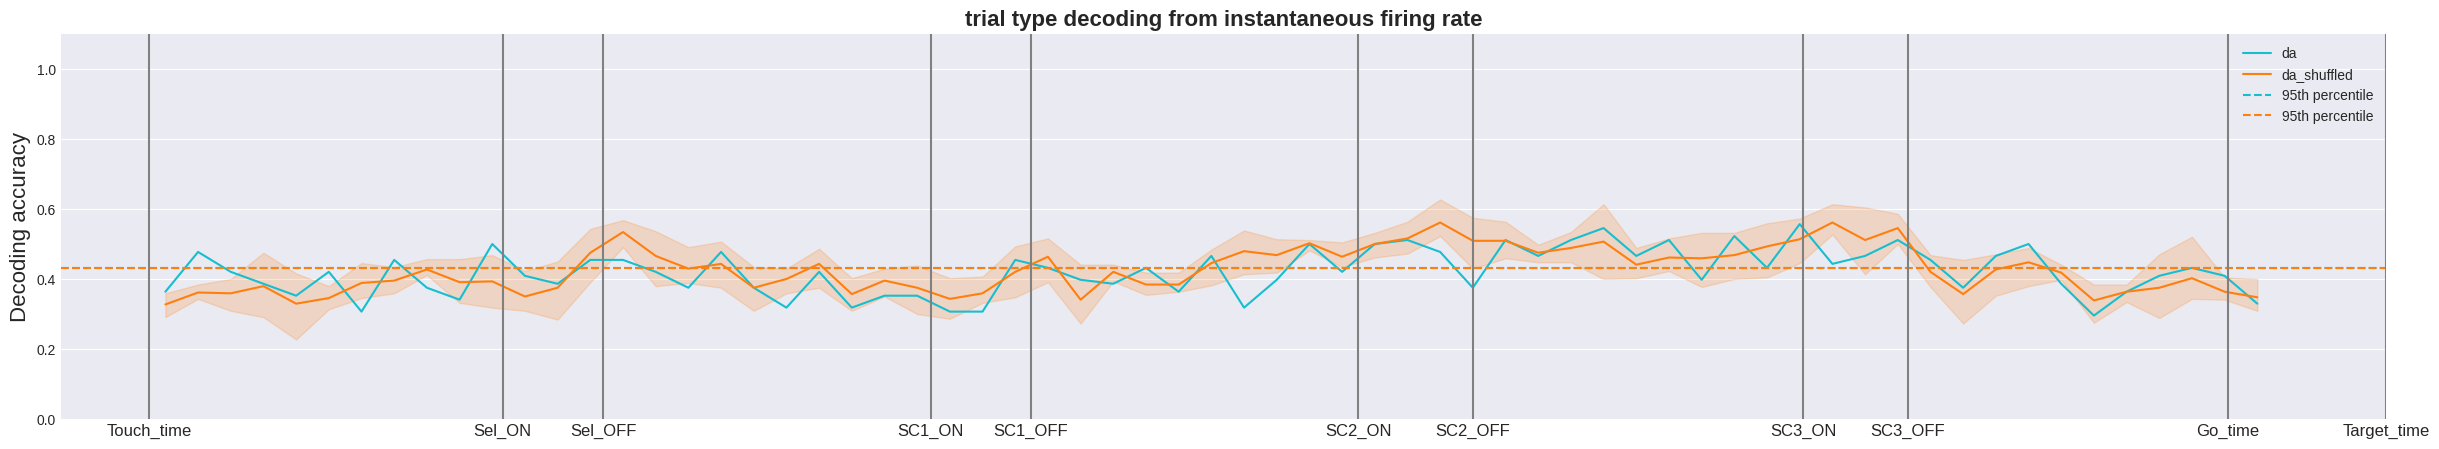

In [9]:
title2= 'instantaneous firing rate'
title1 = 'trial type decoding'
measure = 'fr'

tw =100
plt.figure(figsize=(30,5))
ds_time = np.arange(0, spike_convolved.shape[1], tw) + tw/2
plt.plot(ds_time, da[0], label='da', color='C9');
plt.plot(ds_time, da_shuff.mean(axis=0), color='C1', label="da_shuffled")
da_low, da_high = np.nanpercentile(da_shuff,(5,95), axis=0)
plt.fill_between(ds_time, da_low, da_high, alpha=0.2, color='C1')
plt.axhline(np.nanpercentile(perm, 95), linestyle='--', color='C9', label='95th percentile')
plt.axhline(np.nanpercentile(perm_suf, 95), linestyle='--', color='C1', label='95th percentile')

# plt.axhline(np.nanpercentile(perm_suf, 95))


# for d in range(da_shuff.shape[0]): 
#     plt.plot(da_shuff[d], color='k')


#tick_locations = np.searchsorted(np.arange(0,spike_convolved.shape[1],200), event_vector)
plt.xticks(event_vector, event_labels, fontsize=12)
# Draw a gray dashed line at each x-axis tick
for tick in event_vector:
    plt.axvline(x=tick, color='gray')
plt.ylim(0,1.1)
#plt.xlabel('Time (ms)', fontsize=10)
plt.ylabel('Decoding accuracy', fontsize=16)
plt.title(f'{title1} from {title2}', fontsize=16, weight='bold')
plt.legend()
plt.savefig(result_path+f'{session}_{measure}_{tgt_type}.png')
plt.show()

In [10]:
tgt_type = 'position'
var = spike_convolved

da, perm = classify_3D(var, target[f'{tgt_type}'].values, shuffle=False)
da_shuff, perm_suf = classify_3D(var, target[f'{tgt_type}'].values, shuffle=True, n_repeat=10)

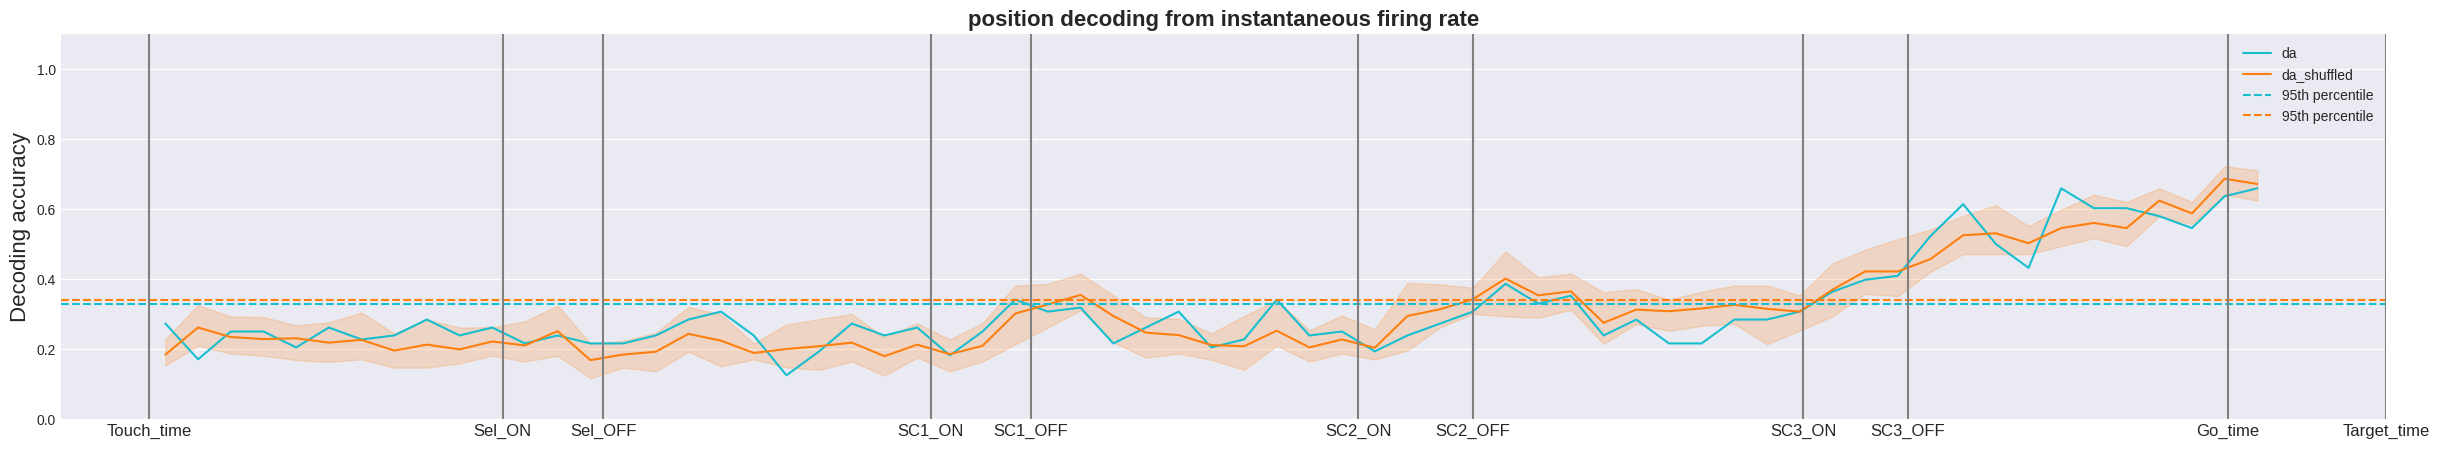

In [11]:
title2= 'instantaneous firing rate'
title1 = 'position decoding'
measure = 'fr'


tw =100
plt.figure(figsize=(30,5))
ds_time = np.arange(0, spike_convolved.shape[1], tw) + tw/2
plt.plot(ds_time, da[0], label='da', color='C9');
plt.plot(ds_time, da_shuff.mean(axis=0), color='C1', label="da_shuffled")
da_low, da_high = np.nanpercentile(da_shuff,(5,95), axis=0)
plt.fill_between(ds_time, da_low, da_high, alpha=0.2, color='C1')
plt.axhline(np.nanpercentile(perm, 95), linestyle='--', color='C9', label='95th percentile')
plt.axhline(np.nanpercentile(perm_suf, 95), linestyle='--', color='C1', label='95th percentile')

# plt.axhline(np.nanpercentile(perm_suf, 95))


# for d in range(da_shuff.shape[0]): 
#     plt.plot(da_shuff[d], color='k')


#tick_locations = np.searchsorted(np.arange(0,spike_convolved.shape[1],200), event_vector)
plt.xticks(event_vector, event_labels, fontsize=12)
# Draw a gray dashed line at each x-axis tick
for tick in event_vector:
    plt.axvline(x=tick, color='gray')
plt.ylim(0,1.1)
#plt.xlabel('Time (ms)', fontsize=10)
plt.ylabel('Decoding accuracy', fontsize=16)
plt.title(f'{title1} from {title2}', fontsize=16, weight='bold')
plt.legend()
plt.savefig(result_path+f'{session}_{measure}_{tgt_type}.png')
plt.show()

# classify synchrony

In [27]:
target

,Unnamed: 0,trial_type,position,type_and_pos
0,0,1,3,2
1,1,1,1,0
2,2,1,2,1
3,3,1,4,3
4,4,1,1,0
...,...,...,...,...
215,215,1,2,1
216,216,2,3,6
217,217,2,1,4
218,218,2,4,7


In [22]:
spike_convolved_shuff_tt = destroy_corr(spike_convolved, target['trial_type'].values, random_state=random_state)
spike_convolved_shuff_pos= destroy_corr(spike_convolved, target['position'].values, random_state=random_state)

[1 2 3]


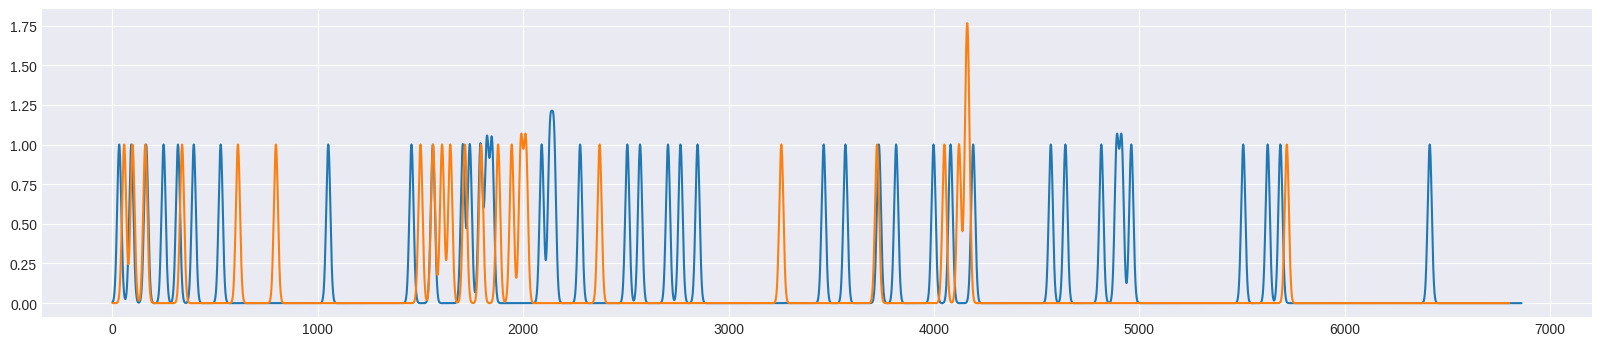

In [26]:
plt.figure(figsize=(20,4))
plt.plot(spike_convolved_shuff_tt[0,:,0])
plt.plot(spike_convolved[0,:,0])

In [ ]:
n_shuff = 10

filtered_Synch_shuff_tt = np.zeros((n_trials, n_times, n_pairs), dtype=np.float32)
filtered_Synch_shuff_pos = np.zeros((n_trials, n_times, n_pairs), dtype=np.float32)


# Calculer la synchronie pour chaque paire filtrée


for i, (r, c) in enumerate(filtered_neuron_pairs):
    for t in range(n_trials):
        filtered_Synch_shuff_tt[t, :, i] = spike_convolved[t, :, r] * spike_convolved_shuff_tt[t, :, c]
        filtered_Synch_shuff_pos[t, :, i] = spike_convolved[t, :, r] * spike_convolved_shuff_pos[t, :, c]

In [11]:
tgt_type = 'trial_type'
var = synchrony

da, perm = classify_3D(var, target[f'{tgt_type}'].values, shuffle=False)
da_shuff, perm_suf = classify_3D(synchrony_shuff_tt, target[f'{tgt_type}'].values, shuffle=False, n_repeat=5)

/tmp/ipykernel_30080/665766212.py:47: RuntimeWarning: Mean of empty slice
  out = Parallel(n_jobs=-1)(delayed(classify_2D)(np.nanmean(X1[:,t:t+200,:], axis=1), y, random_state) for t in time)


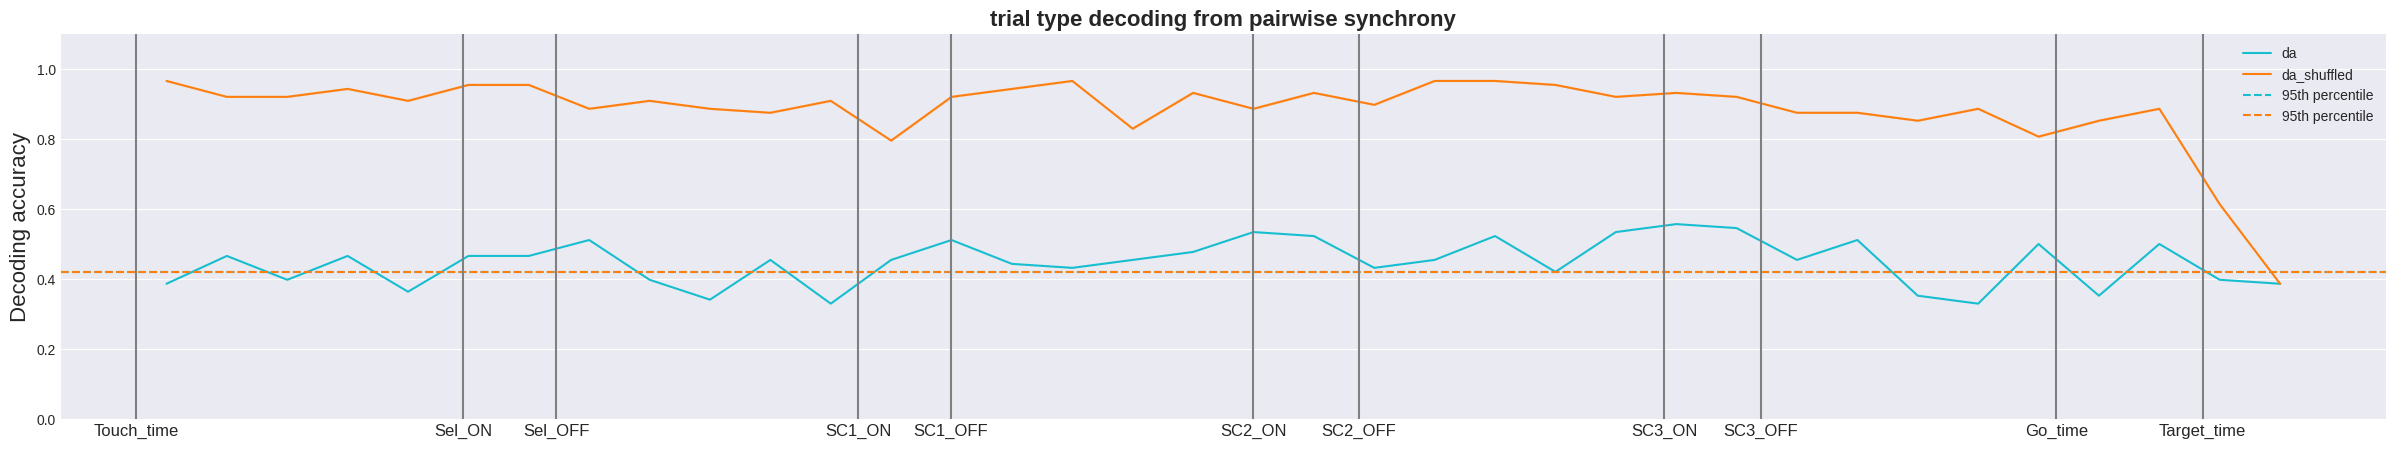

In [12]:
title2= 'pairwise synchrony'
title1 = 'trial type decoding'
measure = 'sync'


plt.figure(figsize=(30,5))
ds_time = np.arange(0, spike_convolved.shape[1], 200) + 100
plt.plot(ds_time, da[0], label='da', color='C9');
plt.plot(ds_time, da_shuff.mean(axis=0), color='C1', label="da_shuffled")
da_low, da_high = np.nanpercentile(da_shuff,(5,95), axis=0)
plt.fill_between(ds_time, da_low, da_high, alpha=0.2, color='C1')
plt.axhline(np.nanpercentile(perm, 95), linestyle='--', color='C9', label='95th percentile')
plt.axhline(np.nanpercentile(perm_suf, 95), linestyle='--', color='C1', label='95th percentile')

# plt.axhline(np.nanpercentile(perm_suf, 95))


# for d in range(da_shuff.shape[0]): 
#     plt.plot(da_shuff[d], color='k')


#tick_locations = np.searchsorted(np.arange(0,spike_convolved.shape[1],200), event_vector)
plt.xticks(event_vector, event_labels, fontsize=12)
# Draw a gray dashed line at each x-axis tick
for tick in event_vector:
    plt.axvline(x=tick, color='gray')
plt.ylim(0,1.1)
#plt.xlabel('Time (ms)', fontsize=10)
plt.ylabel('Decoding accuracy', fontsize=16)
plt.title(f'{title1} from {title2}', fontsize=16, weight='bold')
plt.legend()
plt.savefig(result_path+f'{session}_{measure}_{tgt_type}.png')
plt.show()
plt.show()

In [13]:
tgt_type = 'position'
var = synchrony
da, perm = classify_3D(var, target[f'{tgt_type}'].values, shuffle=False)
da_shuff, perm_suf = classify_3D(synchrony_shuff_pos, target[f'{tgt_type}'].values, shuffle=False, n_repeat=5)

/tmp/ipykernel_30080/665766212.py:47: RuntimeWarning: Mean of empty slice
  out = Parallel(n_jobs=-1)(delayed(classify_2D)(np.nanmean(X1[:,t:t+200,:], axis=1), y, random_state) for t in time)


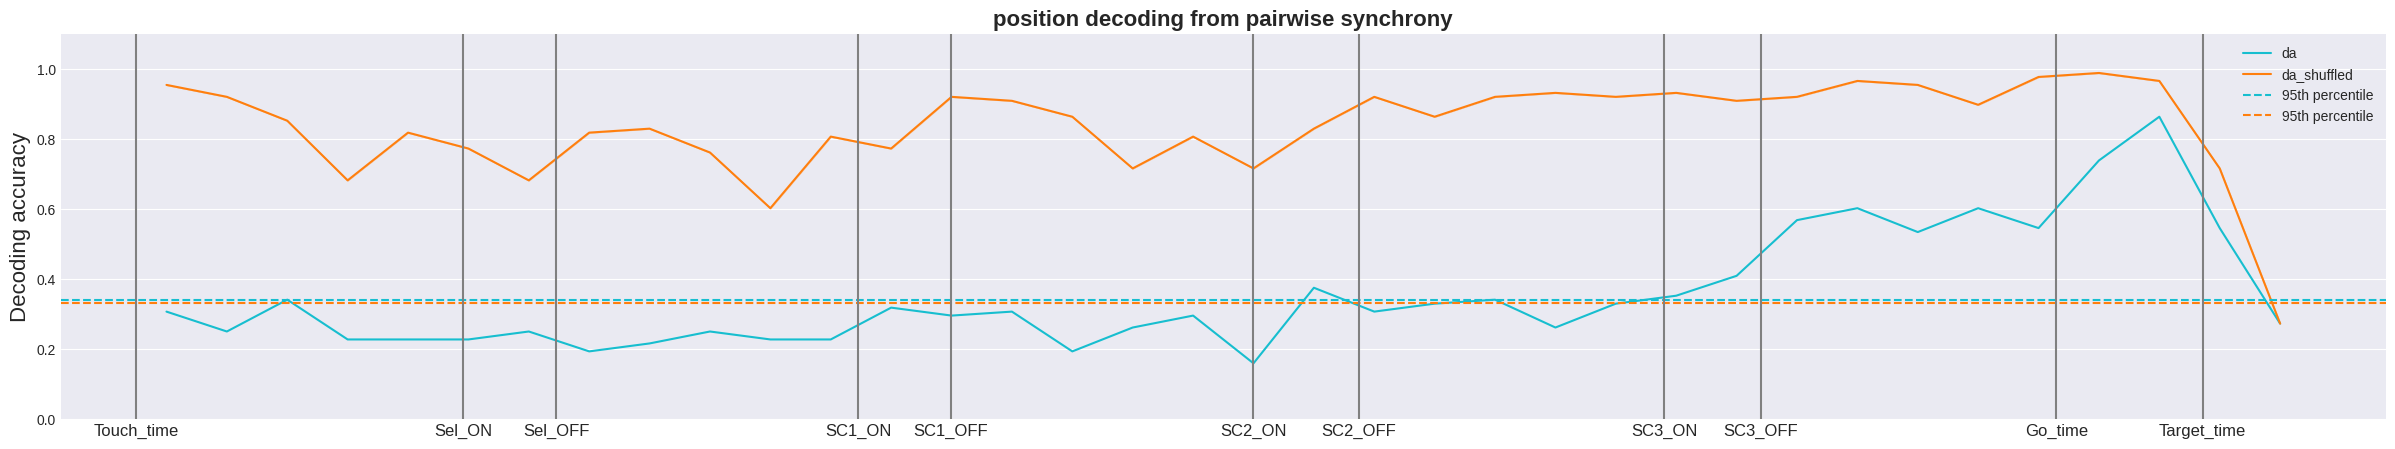

In [14]:
title2= 'pairwise synchrony'
title1 = 'position decoding'
measure = 'sync'


plt.figure(figsize=(30,5))
ds_time = np.arange(0, spike_convolved.shape[1], 200) + 100
plt.plot(ds_time, da[0], label='da', color='C9');
plt.plot(ds_time, da_shuff.mean(axis=0), color='C1', label="da_shuffled")
da_low, da_high = np.nanpercentile(da_shuff,(5,95), axis=0)
plt.fill_between(ds_time, da_low, da_high, alpha=0.2, color='C1')
plt.axhline(np.nanpercentile(perm, 95), linestyle='--', color='C9', label='95th percentile')
plt.axhline(np.nanpercentile(perm_suf, 95), linestyle='--', color='C1', label='95th percentile')

# plt.axhline(np.nanpercentile(perm_suf, 95))


# for d in range(da_shuff.shape[0]): 
#     plt.plot(da_shuff[d], color='k')


#tick_locations = np.searchsorted(np.arange(0,spike_convolved.shape[1],200), event_vector)
plt.xticks(event_vector, event_labels, fontsize=12)
# Draw a gray dashed line at each x-axis tick
for tick in event_vector:
    plt.axvline(x=tick, color='gray')
plt.ylim(0,1.1)
#plt.xlabel('Time (ms)', fontsize=10)
plt.ylabel('Decoding accuracy', fontsize=16)
plt.title(f'{title1} from {title2}', fontsize=16, weight='bold')
plt.legend()
plt.savefig(result_path+f'{session}_{measure}_{tgt_type}.png')
plt.show()
plt.show()

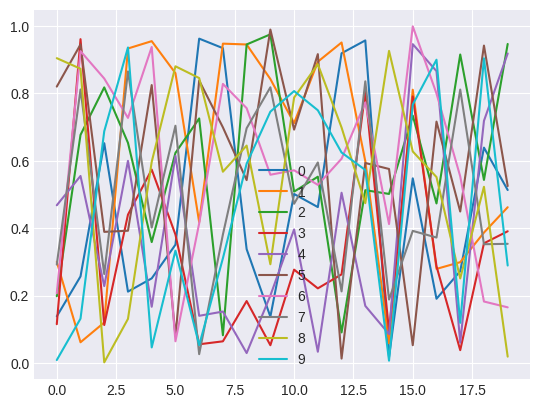

In [14]:
for k in range(10):
    plt.plot(np.random.random(20), color=f'C{k}', label=k)
    plt.legend()